In [1]:
import numpy
import numpy as np
import os

# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"
solution_file = "solution.txt"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)
solution_path = os.path.join("..", "results", solution_file)

# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)
print("Parameter file path:", parameter_path)
print("Solution file path:", solution_path)



def read_decode_input(file_path = decode_input_path):
    """
    Reads the decode_input data from the file.
    Each line represents one letter with 128 elements.
    There are 26 weight vectors each with 128 elements and a transition matrix T with size 26x26.
    The transition matrix T is in row-major order.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    X = np.array(raw_data[:100 * 128], dtype=float).reshape(100, 128)
    W = np.array(raw_data[100 * 128:100 * 128 + 26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[100 * 128 + 26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of decode input:")
    print("X:", X.shape, "W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of X:\n", X[:5])

    return X, W, T

def read_train_struct(file_path = train_struct_path):
    """
    Reads the train_struct data from the file.
    Each line represents a label and a feature vector (in a sparse representation).
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # The last element is empty
        line = line.split(" ")
        dataY.append([int(line[0]) - 1, int(line[1][4:])])
        datax = np.zeros(128, dtype=int)
        for f1 in line[2:]:
            idx, val = f1.split(":")
            datax[int(idx) - 1] = int(val)
        dataX.append(datax)
    
    dataX_np = np.array(dataX, dtype=int)
    print("Shapes of train_struct:")
    print("dataX:", dataX_np.shape, "dataY length:", len(dataY))
    #print("Top 5 rows of dataX:\n", dataX_np[:5])
    
    return dataX_np, dataY

def read_model(file_path = model_path):
    """
    Reads the model data from the file.
    The data consists of weight vectors for each label and a transition matrix T.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    W = np.array(raw_data[:26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of model data:")
    print("W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of W:\n", W[:5])
    
    return W, T

def read_train(file_path = train_data_path):
    """
    Reads the train data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # End of sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of training sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])
    
    return list(zip(dataX, dataY))

import numpy as np

def read_test(file_path = test_data_path):
    """
    Reads the test data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    The function assumes that each example ends when a row with the third column less than 0 is encountered.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:  # Skip the last empty line if it exists
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # Check for the end of a sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of test sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])

    return list(zip(dataX, dataY))

def read_test_decoder_modified(file_path = test_data_path):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array. This function only extracts the features
    and does not deal with the labels.
    """
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Initialize an empty list to store all feature vectors
    dataX = []
    
    for row in raw_data:
        if row:  # Skip any empty lines
            features = row.split(' ')[5:]  # Features start from the 6th element in the row
            feature_vector = list(map(float, features))  # Convert string features to float
            dataX.append(feature_vector)

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    print("Shape of test data for decoder:", dataX_np.shape)
    print("Top 5 feature vectors:\n", dataX_np[:5, :])

    return dataX_np

File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt
Parameter file path: ..\results\Parameters
Solution file path: ..\results\solution.txt


In [11]:
# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"
solution_file = "solution.txt"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)
solution_path = os.path.join("..", "results", solution_file)

# Defining paths for the required files
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
path_train = os.path.join(base_data_path, train_data_file)
path_test = os.path.join(base_data_path, "test_struct.txt")


# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)
print("Parameter file path:", parameter_path)
print("Solution file path:", solution_path)


# Defining paths for the required files
path_decode_input = os.path.join(base_data_path, decode_input_file)
path_train_struct = os.path.join(base_data_path, train_struct_file)
path_train = os.path.join(base_data_path, train_data_file)
path_test = os.path.join(base_data_path, "test_struct.txt")

def read_parameters():
    """
    Reads the decode_input file and extracts X, W, and T parameters.
    X: Feature vectors
    W: Weight vectors
    T: Transition matrix
    """
    raw_data = np.loadtxt(path_decode_input, ndmin=1)
    
    # Splitting raw_data into respective parts for X, W, T
    X = np.array(raw_data[0:100*128]).reshape(100,128)
    W = np.array(raw_data[100*128:100*128+26*128]).reshape(26,128)
    T = np.array(raw_data[100*128+26*128:]).reshape(26,26)
    
    # Debug: Print shapes to ensure correct reshaping
    print(f"Shapes - X: {X.shape}, W: {W.shape}, T: {T.shape}")
    return X, W, T

def read_word_indexes():
    """
    Reads the train.txt file to extract the word indexes.
    """
    # Using np.loadtxt to only load specific column
    word_indexes = np.loadtxt(path_train, usecols=(2,))
    
    # Debug: Print first 5 word indexes to check correctness
    print("First 5 word indexes:", word_indexes[:5])
    return word_indexes

def read_train_struct():
    """
    Reads the train_struct.txt file to extract training data X and labels Y.
    """
    with open(path_train_struct, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1]) # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY

def read_test_struct():
    """
    Reads the test_struct.txt file to extract test data X and labels Y.
    """
    with open(path_test, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1])  # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY
 

File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt
Parameter file path: ..\results\Parameters
Solution file path: ..\results\solution.txt


In [12]:
def read_decode_input():
#function to read the data from decode_input
#100 letters each 128 elements
#26 weight vectors each 128 elements
#T which is a 26 x 26 weight matrix
#T is row major T_11, T_21, T_31 ..

	with open(decode_input_path, "r") as f:
		raw_data = f.read().split("\n")

	X = numpy.array(raw_data[:100*128], dtype=float).reshape(100,128)
	W = numpy.array(raw_data[100*128:100*128+26*128]\
		, dtype=float).reshape(26,128)
	T = numpy.array(raw_data[100*128+26*128:-1], dtype=float).reshape(26,26)
	T = numpy.swapaxes(T, 0, 1)

	return X, W, T


In [13]:
import itertools

def generate_mcombs(alphabet, m):
    """
    Generate all possible combinations of length m from the given alphabet.

    :param alphabet: List or array of possible elements.
    :param m: Length of the combinations to generate.
    :return: List of all combinations of the given length.
    """
    # Initialize a list to hold combinations
    combinations = [[]]
    for i in range(m): 
        # For each position in the combination, append all possible elements
        combinations = [j + [k] for k in alphabet for j in combinations]
    
    # Debug: print the number of combinations generated
    print(f"Generated {len(combinations)} combinations of length {m}")
    
    return combinations

def compute_prob(x, y, W, T):
    """
    Compute the score for a given sequence of observations x and label sequence y.

    :param x: Sequence of observations.
    :param y: Sequence of labels.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The score of the sequence.
    """
    # Initialize sums for features and transitions
    x_sum, t_sum = 0, 0
    # Calculate the score based on features and transitions
    for i in range(len(x) - 1):
        x_sum += np.dot(x[i, :], W[y[i], :])
        t_sum += T[y[i], y[i + 1]]
    # Add the score for the last observation
    x_sum += np.dot(x[len(x) - 1, :], W[y[len(x) - 1], :])

    return x_sum + t_sum


def find_max(x, combinations, W, T):
    """
    Find the most likely label sequence for a given observation sequence x.

    :param x: Sequence of observations.
    :param combinations: All possible label combinations.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The most likely label sequence and its corresponding score.
    """
    # Initialize the max score and corresponding label sequence
    max_val, likely_y = float('-inf'), None
    # Iterate through all combinations to find the best one
    for y in combinations:
        val = compute_prob(x, y, W, T)
        if max_val < val:
            max_val = val
            likely_y = y
    
    # Debug: print the most likely label sequence and its score
    print(f"Most likely sequence: {likely_y}, Score: {max_val}")
    
    return likely_y, max_val

def max_sum(X, W, T):
    """
    Decode the most likely label sequence for each observation sequence in X using the max-sum algorithm.

    :param X: Array of observation sequences.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: Array of most likely label sequences for each observation sequence.
    """
    # Initialize the trellis for dynamic programming
    alpha_len = 26
    trellis = np.zeros((X.shape[0], alpha_len))
    interior = np.zeros(alpha_len)
    y_star = np.zeros(X.shape[0], dtype=int)

    # Fill in the trellis
    for i in range(1, X.shape[0]):
        for j in range(alpha_len):
            for k in range(alpha_len):
                interior[k] = np.dot(W[k], X[i - 1]) + T[k, j] + trellis[i - 1, k]
            trellis[i, j] = np.max(interior)

    # Backtrack to find the most likely sequence
    for i in range(alpha_len):
        interior[i] = np.dot(W[i], X[-1]) + trellis[-1, i]
    y_star[-1] = np.argmax(interior)

    for i in range(X.shape[0] - 1, 0, -1):
        for j in range(alpha_len):
            interior[j] = np.dot(W[j], X[i - 1]) + T[j, y_star[i]] + trellis[i - 1, j]
        y_star[i - 1] = np.argmax(interior)
    
    # Debug: print the final most likely label sequence
    print("Decoded sequence:", y_star)
    
    return y_star

In [18]:
import math
import numpy as np


def compute_log_p(X, y, W, T):
    """
    Computes the log probability of a sequence of labels given inputs X and parameters W, T.
    
    Parameters:
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    W : Weight matrix where each row corresponds to the weights for one label.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    log probability of the label sequence given the inputs and parameters.
    """

    alpha_len = 26  # Alphabet size; ideally passed as a parameter for flexibility
    
    # Initialize the sum of numerator terms for log probability calculation
    sum_num = numpy.dot(W[y[0]], X[0])  # Initial state score
    for i in range(1, X.shape[0]):
        # Add scores for observed states and transitions
        sum_num += numpy.dot(W[y[i]], X[i]) + T[y[i-1], y[i]]
    
    # Initialize the forward trellis for dynamic programming
    trellisfw = numpy.zeros((X.shape[0], alpha_len))
    # Temporary storage for computations at each step
    interior = numpy.zeros(alpha_len)
    # Messages used in the forward pass for dynamic programming
    messages = numpy.zeros((26, 26))

    # Compute forward messages
    for i in range(1, X.shape[0]):
        # Compute interior scores based on current observation and previous states
        numpy.matmul(W, X[i-1], out=interior)
        numpy.add(interior, trellisfw[i-1], out=interior)
        # Compute messages for all transitions
        numpy.add(T, interior[:, numpy.newaxis], out=messages)
        # Normalize to avoid numerical instability
        maxes = messages.max(axis=0)
        numpy.add(messages, -1*maxes, out=messages)
        numpy.exp(messages, out=messages)
        # Sum messages to compute new state values
        numpy.sum(messages, axis=0, out=interior)
        numpy.log(interior, out=interior)
        # Update trellis with log-sums
        numpy.add(maxes, interior, out=trellisfw[i])

    # Compute final scores
    dots = numpy.matmul(W, X[-1])
    numpy.add(dots, trellisfw[-1], out=interior)

    # Normalize final log-sum to prevent underflow
    M = numpy.max(interior)
    numpy.add(interior, -1*M, out=interior)
    numpy.exp(interior, out=interior)
    
    # Calculate log partition function (log Z)
    log_z = M + math.log(numpy.sum(interior))

    # Return the log probability as difference of scores and log partition function
    return sum_num - log_z

import numpy as np
import math

def fb_prob(X, W, T):
    """
    Forward-backward algorithm to compute probabilities over label sequences.
    
    Parameters:
    - X: Input features for each observation in the sequence. Shape: [sequence_length, num_features]
    - W: Weight matrix for label features. Shape: [num_labels, num_features]
    - T: Transition matrix between labels. Shape: [num_labels, num_labels]
    
    Returns:
    - trellisfw: Forward probabilities. Shape: [sequence_length, num_labels]
    - trellisbw: Backward probabilities. Shape: [sequence_length, num_labels]
    - log_z: Log partition function, scalar.
    """
    sequence_length, num_features = X.shape
    num_labels = W.shape[0]
    
    # Initialize forward and backward trellises
    trellisfw = np.zeros((sequence_length, num_labels))
    trellisbw = np.zeros_like(trellisfw)
    
    # Forward pass
    for i in range(1, sequence_length):
        # Compute the weighted input features for all labels at this step
        weighted_inputs = np.dot(W, X[i-1])
        # Update the trellis with contributions from transitions and previous states
        for j in range(num_labels):
            transition_scores = T[:, j] + trellisfw[i-1]
            trellisfw[i, j] = log_sum_exp(weighted_inputs + transition_scores)
    
    # Backward pass
    trellisbw[-1, :] = 0  # Log-probability of 1 at the end of the sequence
    for i in range(sequence_length - 2, -1, -1):
        # Similar to forward pass but in reverse
        weighted_inputs = np.dot(W, X[i+1])
        for j in range(num_labels):
            transition_scores = T[j, :] + weighted_inputs
            trellisbw[i, j] = log_sum_exp(transition_scores + trellisbw[i+1])
    
    # Compute log partition function using the forward trellis
    final_forward_scores = np.dot(W, X[-1]) + trellisfw[-1]
    log_z = log_sum_exp(final_forward_scores)
    
    return trellisfw, trellisbw, log_z

def log_sum_exp(scores):
    """
    Numerically stable computation of log-sum-exp.
    
    Parameters:
    - scores: Input array of scores to be summed in log-space.
    
    Returns:
    - result: Log-sum-exp of input scores.
    """
    max_score = np.max(scores)
    return max_score + np.log(np.sum(np.exp(scores - max_score)))


# The following functions compute gradients for the weight matrix W and transition matrix T respectively
# given a single example (X, y), where X is the feature matrix for the sequence and y is the corresponding label sequence.

def log_p_wgrad(W, X, y, T):
    """
    Computes the gradient of the log probability with respect to the weight matrix W.
    
    Parameters:
    W : Weight matrix where each row corresponds to the weights for one label.
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    Gradient of the log probability with respect to W.
    """
    grad_W = np.zeros(W.shape)  # Gradient matrix for W
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    # Iterate over the sequence
    for i in range(X.shape[0]):
        # Combine forward and backward messages
        marginal = trellisfw[i] + trellisbw[i]
        # Incorporate the evidence from input features
        evidence = np.matmul(W, X[i])
        # Subtract the log partition function
        marginal -= log_z
        # Normalize to get probabilities
        marginal = np.exp(marginal)

        # Calculate the gradient for the current position
        for j in range(26):  # Iterate over all possible labels
            if j == y[i]:
                grad_W[j] += X[i]  # Add the feature vector for the true label
            grad_W[j] -= marginal[j] * X[i]  # Subtract the expected feature vector

    return grad_W


def log_p_tgrad(T, X, y, W):
    """
    Computes the gradient of the log probability with respect to the transition matrix T.
    
    Parameters:
    - T: Transition matrix where T[i, j] is the transition weight from label i to label j.
    - X: 2D array where each row is the feature vector for one observation.
    - y: 1D array of labels corresponding to the observations in X.
    - W: Weight matrix where each row corresponds to the weights for one label.
    
    Returns:
    - grad: Gradient of the log probability with respect to T.
    """
    num_labels = T.shape[0]
    grad = np.zeros_like(T)  # Initialize the gradient matrix for T with zeros
    
    # Compute the forward and backward probabilities and the log partition function (log Z)
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    for i in range(X.shape[0] - 1):
        potential = np.zeros_like(T)  # Potential for transitions
        
        # Calculate potential scores for transitions considering features and transition scores
        for j in range(num_labels):
            for k in range(num_labels):
                potential[j, k] = np.dot(W[j], X[i]) + np.dot(W[k], X[i+1]) + T[j, k]
        
        potential += trellisfw[i][:, np.newaxis] + trellisbw[i+1]
        potential -= log_z  # Normalize by subtracting log partition function
        potential = np.exp(potential)  # Convert to probabilities
        
        # Update the gradient
        grad[y[i], y[i+1]] += 1  # Increment gradient for observed transition
        grad -= potential  # Subtract expected transition probabilities
        
    return grad



# Example usage:
# Assuming X, y, W, and T are already loaded
# grad_W = log_p_wgrad(W, X, y, T)
# grad_T = log_p_tgrad(T, X, y, W)
# The gradients can be used in an optimization algorithm to update W and T


# Q5 implementation

In [7]:
import numpy as np
import math
from skimage.transform import rotate
import matplotlib.pyplot as plt
#Rotate X by alpha degrees (angle) in a counterclockwise direction around its center point.
#This may enlarge the image.
#So trim the result back to the original size, around its center point.
def rotate_image(X, alpha):
    """
    Rotate image X by alpha degrees in a counterclockwise direction.
    The image is enlarged to fit the entire rotated image and then trimmed back to the original size.
    """
    # Rotate the image
    Y = rotate(X, alpha, resize=True, mode='edge', preserve_range=True)
    
    # Calculate dimensions to trim the rotated image back to the original size
    lenx1, lenx2 = X.shape
    leny1, leny2 = Y.shape
    fromx = math.floor((leny1 + 1 - lenx1) / 2)
    fromy = math.floor((leny2 + 1 - lenx2) / 2)
    
    # Trim the result back to the original size, around its center point
    Y_trimmed = Y[fromx:fromx + lenx1, fromy:fromy + lenx2]
    
    return Y_trimmed


C:\Users\prana\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [8]:
import numpy as np

def translate(X, offset):
    """
    Translate image X by given horizontal and vertical offsets.
    
    Parameters:
    - X: 2D numpy array representing the input image.
    - offset: Tuple (ox, oy) representing horizontal and vertical offsets.
    
    Returns:
    - Y: 2D numpy array representing the translated image.
    """
    # Copy input image to avoid modifying the original image
    Y = np.copy(X)
    ox, oy = offset  # Unpack the offsets
    lenx, leny = X.shape  # Dimensions of the input image
    
    # Translation logic
    if ox > 0 and oy > 0:
        Y[ox:lenx, oy:leny] = X[:lenx-ox, :leny-oy]
    else:
        # General case for handling negative offsets
        Y[max(0, ox):min(lenx, lenx+ox), max(0, oy):min(leny, leny+oy)] = X[max(0, -ox):min(lenx, lenx-ox), max(0, -oy):min(leny, leny-oy)]
    
    return Y



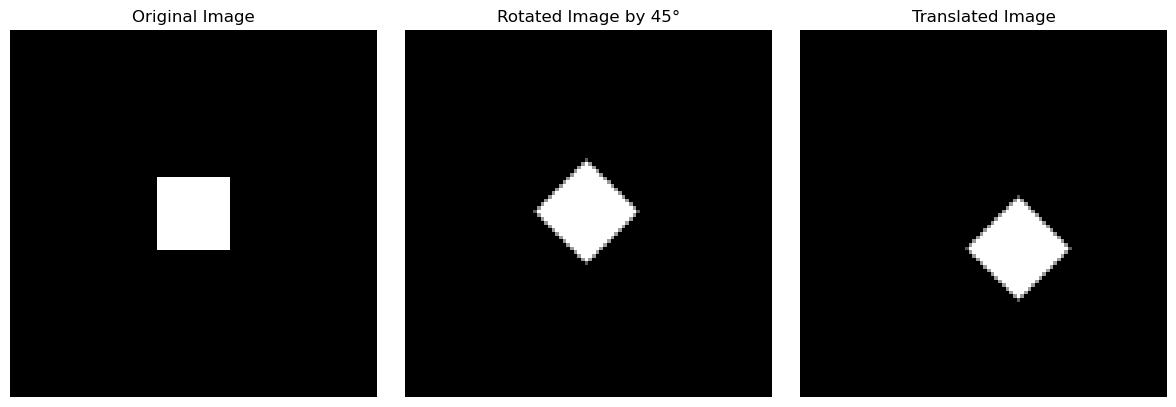

In [9]:
# Creating a black canvas with a white square EXAMPLE USEAGE
canvas_size = 100
square_size = 20
X = np.zeros((canvas_size, canvas_size))
start = canvas_size // 2 - square_size // 2
end = start + square_size
X[start:end, start:end] = 1

# Rotate the image by 45 degrees
alpha = 45
rotated_img = rotate_image(X, alpha)

# Translate the rotated image by (10, 10)
offset = (10, 10)
translated_img = translate(rotated_img, offset)

# Display the original, rotated, and translated images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rotated_img, cmap='gray')
plt.title(f'Rotated Image by {alpha}°')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(translated_img, cmap='gray')
plt.title('Translated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def word_accuracy(words1, words2):
    """
    Computes the accuracy of predicted words against the ground truth.

    Parameters:
    words1 (list): List of numpy arrays representing the ground truth words.
    words2 (list): List of numpy arrays representing the predicted words.

    Returns:
    float: The word accuracy.
    """
    count = 0
    for i, j in zip(words1, words2):
        if np.array_equal(i, j):
            count += 1
    return count / len(words1)
    
def get_test_accuracy(y1, y2):
    """
    Computes the accuracy of individual letters in the test set.

    Parameters:
    y1 (numpy.ndarray): Ground truth labels.
    y2 (numpy.ndarray): Predicted labels.

    Returns:
    float: The letter-wise accuracy.
    """
    count = 0
    for i, j in zip(y1, y2):
        if np.array_equal(i, j):
            count += 1
    return count / len(y1)

def form_words(y1, y2):
    """
    Forms words from the sequence of labels.

    Parameters:
    y1 (numpy.ndarray): Ground truth labels.
    y2 (numpy.ndarray): Predicted labels.

    Returns:
    tuple: Two lists containing ground truth words and predicted words, respectively.
    """
    word_ends = np.insert(np.where(read_word_indexes() == -1)[0], 0, 0)
    given_words, pred_words = [], []
    start = 0
    for i in range(len(word_ends) - 1):
        end = word_ends[i + 1] + 1
        g_word = y1[start:end]
        p_word = y2[start:end]
        start = end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words

def test_params():
    """
    Tests the CRF parameters and prints the letter-wise and word-wise accuracy.
    """
    X_test, y_test = read_test_struct()  # Read the test data
    a = np.loadtxt("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/result/Parameters", usecols=(0,))  # Change this path to your parameters file
    W = np.array(a[:26 * 128].reshape(26, 128))  # Weight matrix
    T = np.array(a[26 * 128:26 * 128 + 26 * 26].reshape(26, 26))  # Transition matrix
    
    # Predict labels using max_sum algorithm
    y_pred = max_sum(X_test, W, T)
    y_pred = [y + 1 for y in y_pred]  # Adjust labels if necessary
    y_test = y_test.reshape(26198,)  # Reshape y_test for comparison
    
    # Save predictions to a file
    np.savetxt("prediction", y_pred)
    
    # Compute and print letter-wise accuracy
    test_acc = get_test_accuracy(y_test, y_pred)
    print("Test letter wise accuracy=", test_acc * 100)
    
    # Compute and print word-wise accuracy
    given_words, pred_words = form_words(y_test, y_pred)
    w_acc = word_accuracy(given_words, pred_words)
    print("Test word accuracy=", w_acc * 100)


test_params()

dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]
Decoded sequence: [24 11 14 ...  8 13  6]
Test letter wise accuracy= 0.809222078021223
First 5 word indexes: [ 2.  3. -1.  2.  3.]
Test word accuracy= 0.0


In [45]:
import numpy as np
from scipy.optimize import fmin_bfgs
import time
import pickle

# Reading training data and initial model parameters
X_y = read_train()  # Reading training data
W, T = read_model()  # Reading initial model parameters

def func(params, *args):
    """
    Objective function as specified in the handout. It calculates the negative log likelihood
    of the data given the parameters, regularized with L2 norm of the parameters.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    float: The value of the objective function.
    """
    # Reshape the parameters back into W and T matrices
    W = params[:26*128].reshape((26, 128))
    T = params[26*128:].reshape((26, 26))
    data = args[0]
    C = args[1]

    # Calculate the log likelihood sum over all examples
    log_sum = sum(compute_log_p(example[0], example[1], W, T) for example in data)

    # Calculate the L2 norm of W for regularization
    norm_w = np.linalg.norm(W, axis=1)**2
    
    log_value = (1/len(data))*log_sum
    print(log_value)
    
    # Objective function calculation
    return -1*(C/len(data))*log_sum + 0.5*np.sum(norm_w) + 0.5*np.sum(np.square(T))

def func_prime(params, *args):
    """
    Derivative of the objective function as specified in the handout.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    numpy.ndarray: Gradient of the objective function with respect to the parameters.
    """
    # Reshape the parameters back into W and T matrices
    W = params[:26*128].reshape((26, 128))
    T = params[26*128:].reshape((26, 26))
    data = args[0]
    C = args[1]

    # Initialize gradients for W and T
    log_grad_w = np.zeros((26, 128))
    log_grad_t = np.zeros((26, 26))

    # Accumulate gradients from all examples
    for example in data:
        log_grad_w += log_p_wgrad(W, example[0], example[1], T)
        log_grad_t += log_p_tgrad(T, example[0], example[1], W)

    # Apply regularization term
    log_grad_w = -1*C/len(data)*log_grad_w + W
    log_grad_t = -1*C/len(data)*log_grad_t + T

    # Return the concatenated gradient vector
    return np.concatenate([log_grad_w.reshape(26*128), log_grad_t.reshape(26*26)])

# Initial guess for the optimization
initial_guess = np.zeros((26*128 + 26*26))

def get_params(x_y, C):
    """
    Optimizes the model parameters using the BFGS algorithm.
    
    Parameters:
    x_y (list): The training dataset.
    """
    t0 = time.time()
    ret = fmin_bfgs(func, initial_guess, fprime=func_prime, args=(x_y, C),
                    maxiter=5, retall=True, full_output=True)
    t1 = time.time()

    # Saving the optimized parameters
    with open("best_Weights_Q5_c1", "wb") as f: #
        pickle.dump(ret, f)
    np.savetxt("best_Weights_Q5_c1", ret[0]) #best_Weights_Q5_c1, c10, c100 and c1000 were saved here

    print(f"Time: {t1-t0}")
    
    
#get_params(X_y, 1)


def get_params(x_y):
    t0 = time.time()
    ret=fmin_bfgs(func, initial_guess, fprime=func_prime, args=(x_y,100), maxiter=2, retall=True, full_output=True)
    t1 = time.time()
    with open("best_Weights_Q5_c100","+bw") as f :
        pickle.dump(ret,f)
    numpy.savetxt("best_Weights_Q5_c100",ret[0])
    
    print(f"Time: {t1-t0}")
    
get_params(X_y)

Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Shapes of model data:
W: (26, 128) T: (26, 26)
-24.594932941033264
-21.034947183274973
-24.894957407087837
-19.928786397570388
-22.045980520918935
-19.745378279235304
-20.82009648853048
-19.76014747926721
-19.74189588597446
-19.74841905845022
-19.741446148414504
-19.741721987836122
-19.741474037494434
-19.741448031237233
-19.741466113508135
-19.741472260147287
-19.74147365832224
-19.741473957414794
-19.7414740206175
-19.74147403393918
-19.74147403674561
-19.741474037336744
-19.74147403746128
-19.74147403748748
-19.741474037493017
-19.74147403749416
-19.74147403749443
-19.7414740374945
-19.741474037494452
-19.74147403749444
-19.741474037494438
-19.741474037494434
-21.034947183274973
-19.747344085789592
-22.354336524748014
-20.159277682926895
-19.78758014

In [24]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as mp
import numpy as np

def train(xtrain, y_train, c):
    """
    Trains an SVM classifier on the provided training data.
    
    Parameters:
    - xtrain: The feature vectors for the training data.
    - y_train: The labels for the training data.
    - c: Regularization parameter for the SVM classifier.
    
    Returns:
    - clf: The trained SVM classifier.
    """
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(xtrain, y_train)
    return clf

def test(model, X_test, y_test):
    """
    Tests a trained model on the provided test data.
    
    Parameters:
    - model: The trained classifier to be tested.
    - X_test: The feature vectors for the test data.
    - y_test: The labels for the test data.
    
    Returns:
    - y_pred: Predictions made by the model on the test data.
    - score: The accuracy of the model on the test data.
    """
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return y_pred, score

def form_words(y1, y2):
    """
    Forms words from sequences of labels, where word boundaries are determined by a special index.
    
    Parameters:
    - y1: The sequence of actual labels.
    - y2: The sequence of predicted labels.
    
    Returns:
    - given_words: A list of actual words formed from the sequence of actual labels.
    - pred_words: A list of predicted words formed from the sequence of predicted labels.
    """
    word_ends = []
    word_idx = read_word_indexes()
    word_ends = np.insert(np.where(word_idx == -1), 0, 0)
    given_words = []
    pred_words = [] 
    start = 0
    for i in range(len(word_ends)-1):   
        end = word_ends[i+1] + 1
        g_word = y1[start:end]
        p_word = y2[start:end]
        start = end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words    

def word_accuracy(words1, words2):
    """
    Calculates the accuracy of word predictions by comparing the actual and predicted words.
    
    Parameters:
    - words1: The list of actual words.
    - words2: The list of predicted words.
    
    Returns:
    - Accuracy: The fraction of correctly predicted words.
    """
    count = 0
    for i, j in zip(words1, words2):
        if(np.array_equal(i, j)):
            count += 1
    return count / len(words1)

def plot():
    """
    Plots the letter-wise and word-wise accuracies of the SVM model for different values of C.
    """
    C = [1, 10, 100, 1000]
    test_accuracy = []
    word_acr = []
    X_train, y_train = read_train_struct()
    X_test, y_test = read_test_struct()

    for i in C: 
        y_train = y_train.ravel()
        clf = train(X_train, y_train, i / len(y_train))
        y_pred, score = test(clf, X_test, y_test)
        test_accuracy.append(score * 100)
        y_train = y_train.reshape(len(y_train,))
        given_words, pred_words = form_words(y_test, y_pred)
        w_acc = word_accuracy(given_words, pred_words)
        word_acr.append(w_acc * 100)

    mp.figure(1)
    mp.plot(C, test_accuracy)
    mp.title('Letter wise Accuracy vs C - SVM-MC')
    mp.ylabel('Accuracy')
    mp.xlabel('C')

    mp.figure(2)
    mp.plot(C, word_acr)
    mp.title('Word wise Accuracy vs C - SVM-MC')
    mp.ylabel('Accuracy')
    mp.xlabel('C')

In [41]:
import os.path
import matplotlib.pyplot as mp
import copy

path = os.path.join(base_data_path, "transform.txt")


f = open(path, 'r')
x=[0,500,1000,1500]

train_data={}

def restore_range(OldValue,OldMax,OldMin,NewMin,NewMax):
    OldRange = (OldMax - OldMin)
    if (OldRange == 0):
        NewValue = NewMin
    else:
        NewRange = (NewMax - NewMin)  
        NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
    return np.round(NewValue)



#method to peform transformation on the data and check robustness
def tamper(model, WTfile):
    test_acc =[]
    wrd_acr =[]
    y_pred=[]

    X_train, y_train = read_train_struct()
    X_test, y_test = read_test_struct()
    for num in x:
        print(num)
        X_trans = copy.deepcopy(X_train)
        
        # Reset the file pointer to the beginning for each iteration
        f.seek(0)
        
        for i in range(num):
            line=next(f)
            line=line.split(' ')
            offset=[]
            c=X_trans[int(line[1]),:]
            example=np.array(c).reshape(16,8)    
            if(line[0]=='r'):
                alpha= float(line[2])
                x_result = rotate_image(example,alpha)
                x_result = x_result.reshape(128,)
            elif (line[0]=='t'):
                offset.append(int(line[2]))
                offset.append(int(line[3]))
                x_result= translate(example,offset)
                x_result= x_result.reshape(128,)  
            x_max_old=0
            x_min_old=255
            x_min_new=0
            x_max_new=1
            new_value=restore_range(x_result,x_max_old,x_min_old,x_min_new,x_max_new)
            X_trans[int(line[1])]=new_value
        #training 
        if(num==0):
            if(model=='svm'):
                clf= train(X_train,y_train,1000/len(y_train))
            else:      
                x_y= X_train,y_train
                #get_params(x_y) ##### opt
                a= np.loadtxt(WTfile, usecols=(0,)) ### WTfile is weight/parameters file. 
                W= np.array(a[:26*128].reshape(26,128))
                T= np.array(a[26*128:26*128+26*26].reshape(26,26))
        #training with more than 1 transformation 
        else:
            if(model=='svm'):
                clf= train(X_trans,y_train,1000/len(y_train))
            else:      
                x_y= X_trans,y_train
                print(type(x_y))
                #get_params(x_y) ###### opt
                a= np.loadtxt(WTfile, usecols=(0,))
                W= np.array(a[:26*128].reshape(26,128))
                T= np.array(a[26*128:26*128+26*26].reshape(26,26))   

        #testing 
        if(model=='svm'):
            y_pred,score= test(clf,X_test,y_test)
        else:
            
            y_pred = max_sum(X_test, W, T)
            y_pred=[y+1 for y in y_pred]
            y_test=y_test.reshape(26198,)
            numpy.savetxt("prediction_Q5",y_pred)
            #y_pred=np.array(y_pred).reshape(len(y_pred,))               
            #print((y_test))
            #print((y_pred))
            score= get_test_accuracy(y_test,y_pred) ##### max_sum_decode
        test_acc.append(score*100)
        y_test=y_test.reshape(len(y_test,))
        given_words, pred_words= form_words(y_test,y_pred)
        w_acc= word_accuracy(given_words,pred_words)
        wrd_acr.append(w_acc*100)
    return test_acc,wrd_acr


In [ ]:
def test_params(filepath):
    X_test,y_test=read_test_struct()
    y_pred=[]
    
    a=numpy.loadtxt(filepath, usecols=(0,))
    W=numpy.array(a[:26*128].reshape(26,128))
    T=numpy.array(a[26*128:26*128+26*26].reshape(26,26))
    
    y_pred = max_sum(X_test, W, T)
    y_pred=[y+1 for y in y_pred]
    y_test=y_test.reshape(25953,)
    numpy.savetxt("prediction",y_pred)
    
    #print(y_pred)
    #print(y_test)
    
    test_acc=get_test_accuracy(y_test,y_pred)
    test_accuracy=(test_acc*100)
    print("Test letter wise accuracy=",test_accuracy)
    
    y_test=y_test.reshape(len(y_test,))
    given_words, pred_words=form_words(y_test,y_pred)
    
    w_acc=word_accuracy(given_words,pred_words)
    word_acr =(w_acc*100)
    print("Test word accuracy=",word_acr)
    
    return word_acr, test_accuracy

dataX shape: (25953, 128), dataY shape: (25953, 1)
First 5 labels: [[ 0]
 [10]
 [ 4]
 [14]
 [12]]
dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]
0


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]
500


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]
1000


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]
1500


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


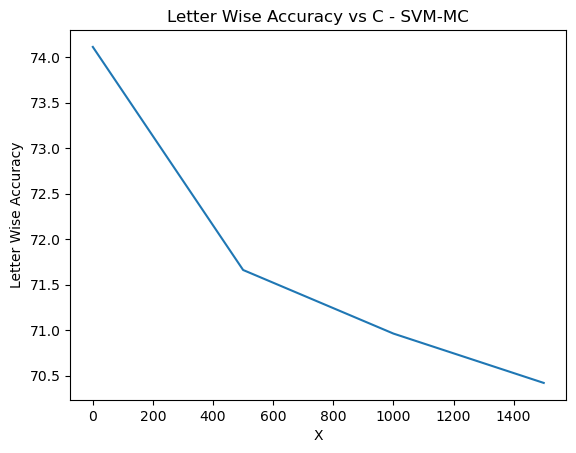

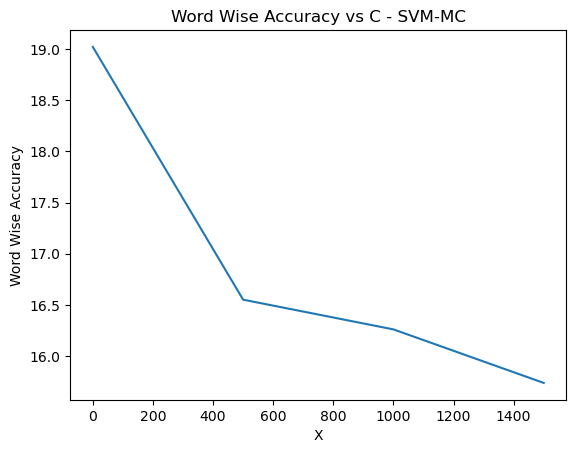

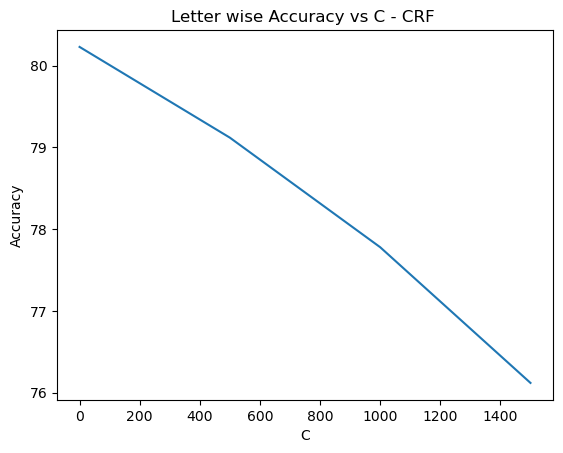

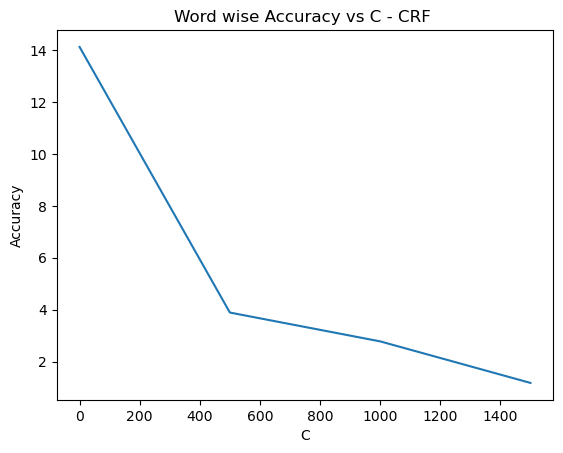

In [43]:

def test_tamper_svm():
    test_accuracy,word_acr=tamper('svm')
    mp.figure(70)
    mp.title('Letter Wise Accuracy vs C - SVM-MC')
    mp.plot(x,test_accuracy)
    mp.ylabel('Letter Wise Accuracy')
    mp.xlabel('X')
    mp.figure(77)
    mp.plot(x,word_acr)
    mp.ylabel('Word Wise Accuracy')
    mp.xlabel('X')
    mp.title('Word Wise Accuracy vs C - SVM-MC')

def test_tamper_crf(file):
    test_accuracy,word_acr=tamper('crf')
    mp.figure(108)
    mp.title('Letter Wise Accuracy vs C - CRF')
    mp.plot(x,test_accuracy)
    mp.ylabel('Letter Wise Accuracy')
    mp.xlabel('X')
    mp.figure(107)
    mp.plot(x,word_acr)
    mp.ylabel('Word Wise Accuracy')
    mp.xlabel('X')
    mp.title('Word Wise Accuracy vs C - CRF')
    
test_tamper_svm()

#test_tamper_crf("best_Weights_Q5_c1")

# for different crf accuracies, we change the file here from best_Weights_Q5_c1, best_Weights_Q5_c10, c100 and c1000. 
# For each, we get seperate word and letter wise accuracy, which is hardcoded in the plot function below

def plot():
    x=[0,500,1000,1500]
    test_accuracy=[80.23,79.12,77.78,76.12]
    word_acr=[14.12,3.89,2.78,1.18]
    mp.figure(1)
    mp.plot(x,test_accuracy)
    mp.title('Letter wise Accuracy vs C - CRF ')
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.figure(2)
    mp.plot(x,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')  
    mp.title('Word wise Accuracy vs C - CRF ')    

plot()